# Introduction to `geoplanar`

Welcome to `geoplanar`, a package for [planar enforcement](https://ibis.geog.ubc.ca/courses/klink/gis.notes/ncgia/u12.html#SEC12.6) for polygon (multipolygon) [GeoSeries/GeoDataFrames](https://github.com/geopandas/geopandas).


In [1]:
import geoplanar
import geopandas


/Users/noraizasif/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


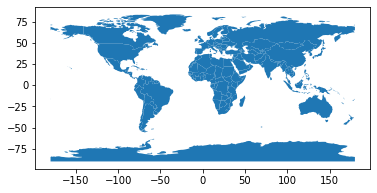

In [2]:
# Data Source: https://geopandas.org/docs/user_guide/mapping.html
world1 = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world1.plot()

In [7]:
world1.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


US and Canada borders are used in this notebook to check for any violations of nonplanar enforcement.

### Data from Ethiopia

In [8]:
Africa= world1[world1['continent'] == "Africa"]
Africa.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
11,83301151,Africa,Dem. Rep. Congo,COD,66010.0,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
12,7531386,Africa,Somalia,SOM,4719.0,"POLYGON ((41.58513 -1.68325, 40.99300 -0.85829..."
13,47615739,Africa,Kenya,KEN,152700.0,"POLYGON ((39.20222 -4.67677, 37.76690 -3.67712..."


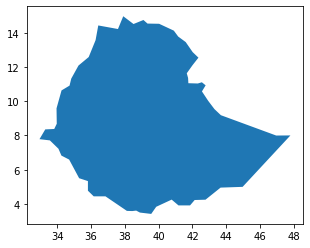

In [9]:
ethiopia = world1[world1.name == 'Ethiopia']
ethiopia.plot()

In [11]:
# ethiopia.crs

### Data from Somalia

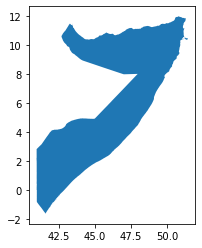

In [12]:
# Geospatial data for Somalioa was retrieved from https://geodata.lib.berkeley.edu/catalog/stanford-jk730nk3464
somalia = geopandas.read_file("SOM_adm0.shp")
somalia.plot()

In [14]:
somalia= somalia.set_crs(ethiopia.crs)
somalia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
somalia.head()

,ID_0,ISO,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,NAME_VARIA,NAME_NONLA,NAME_FRENC,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,210,SOM,Somalia,SOMALIA,Somalia,Somalia,British Somaliland|Italian Somaliland|Oltre Gi...,None,None,Somalie,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"MULTIPOLYGON (((41.61375 -1.60792, 41.61375 -1..."


In [16]:
eth_som = ethiopia.append(somalia)

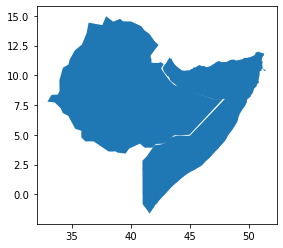

In [17]:
eth_som.plot()

### Subsample of Data for Border

We have appended the Ethiopoa gdf to the Somalia gdf. For now, however, we are going to zoom in on a subset of the border region to investigate things further:

In [23]:
from shapely.geometry import box

clipper = geopandas.GeoDataFrame(geometry =[box(40, 2.5, 48, 9)])

In [45]:
etho_border = geopandas.clip(clipper, ethiopia)
somborder = geopandas.clip(clipper, somalia)


<ipython-input-45-048faed0b497>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  etho_border = geopandas.clip(clipper, ethiopia)
<ipython-input-45-048faed0b497>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  somborder = geopandas.clip(clipper, somalia)


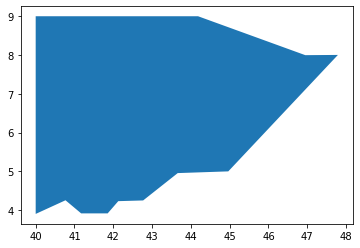

In [26]:
etho_border.plot()

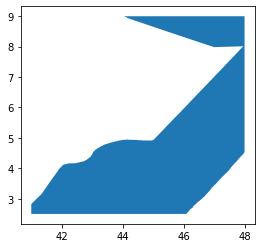

In [29]:
somborder.plot()

### Checking for Border discrepancies

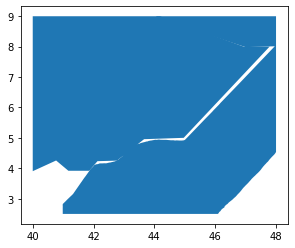

In [30]:
ethosom = etho_border.append(somborder)
ethosom.reset_index(inplace=True)
ethosom.plot()

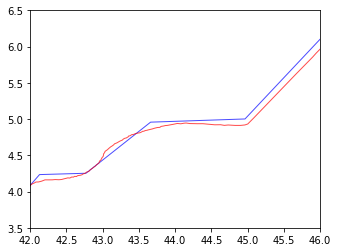

In [94]:
base = etho_border.plot(alpha=0.7, facecolor='none', edgecolor='blue')
_ = somborder.plot(alpha=0.7, facecolor='none', edgecolor='red', ax=base)
_ = base.set_xlim(42, 46)
_ = base.set_ylim(3.5, 6.5)


Here we see an example of the kinds of problems that can occur when combining different geospatial datasets that have been constructed by different researchers. 

We can use geoplanar to fix these cartographic issues.
We start by fixing the problem of overlaps/overshoots and proceed to remove any holes.
Geoplanar has two default settings, the section below is intented to apply the methods to fix the issues and also to change the defaults and see the outcomes.

## Fixing Overlaps/Overshoots

In [95]:
ethosom = etho_border.append(somborder)
ethosom.reset_index(inplace=True)
ethosom['COUNTRY'] = ["ETHIOPIA", "SOMALIA"]
ethosom.area

0    27.613872
1    19.973735
dtype: float64

In [96]:
# Checking for overlaps
geoplanar.is_overlapping(ethosom)

True

In [97]:
# Fixing Overlaps default
border_overlaps_removed = geoplanar.trim_overlaps(ethosom)
border_overlaps_removed.area

0    27.473982
1    19.973735
dtype: float64

## Fixing undershoots/holes

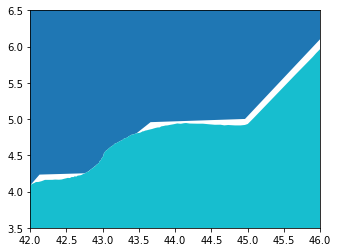

In [98]:
base = border_overlaps_removed.plot(column='COUNTRY')
_ = base.set_xlim(42, 46)
_ = base.set_ylim(3.5, 6.5)


In [99]:
holes = geoplanar.holes(border_overlaps_removed)

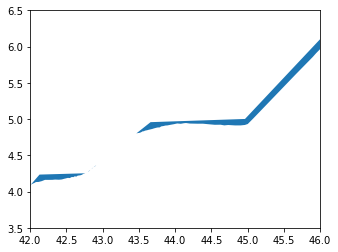

In [100]:
base = holes.plot()
_ = base.set_xlim(42, 46)
_ = base.set_ylim(3.5, 6.5)



In [101]:
holes.shape

(10, 3)

In [102]:
final = geoplanar.fill_holes(border_overlaps_removed)

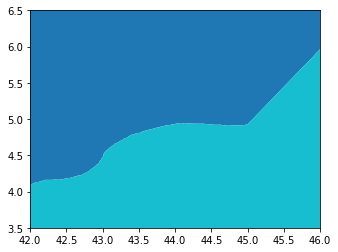

In [103]:
base = final.plot(column='COUNTRY')
_ = base.set_xlim(42, 46)
_ = base.set_ylim(3.5, 6.5)



In [104]:
h1 = geoplanar.holes(final)

In [105]:
h1.shape 


(3, 3)

### Case1: Changing Defaults ( Overlaps Only)

In [107]:
ethosom = etho_border.append(somborder)
ethosom.reset_index(inplace=True)
ethosom['COUNTRY'] = ["ETHIOPIA", "SOMALIA"]
ethosom.area

0    27.613872
1    19.973735
dtype: float64

In [109]:
border_overlaps_removed_new = geoplanar.trim_overlaps(ethosom, largest=False)
border_overlaps_removed_new.area

0    27.613872
1    19.833845
dtype: float64

In [111]:
holes_new = geoplanar.holes(border_overlaps_removed_new)
holes_new.shape

(8, 3)

In [112]:
final_new = geoplanar.fill_holes(border_overlaps_removed_new)

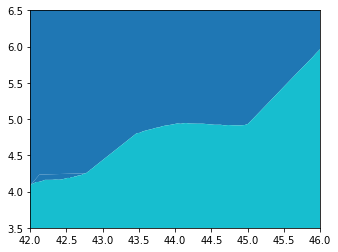

In [117]:
base = final_new.plot(column='COUNTRY')
_ = base.set_xlim(42, 46)
_ = base.set_ylim(3.5, 6.5)



In [113]:
h2 = geoplanar.holes(final_new)
h2.shape

(7, 3)

### Case 2: Changing Defaults ( Holes Only)

In [114]:
ethosom = etho_border.append(somborder)
ethosom.reset_index(inplace=True)
ethosom['COUNTRY'] = ["ETHIOPIA", "SOMALIA"]
ethosom.area

0    27.613872
1    19.973735
dtype: float64

In [115]:
border_overlaps_removed_2 = geoplanar.trim_overlaps(ethosom)
border_overlaps_removed_2.area

0    27.473982
1    19.973735
dtype: float64

In [116]:
final2 = geoplanar.fill_holes(border_overlaps_removed_2, largest=False)

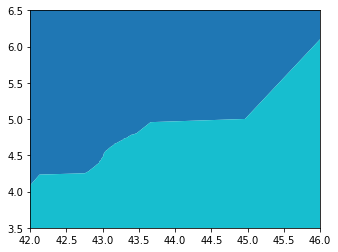

In [118]:
base = final2.plot(column='COUNTRY')
_ = base.set_xlim(42, 46)
_ = base.set_ylim(3.5, 6.5)



In [119]:
h3 = geoplanar.holes(final2)
h3.shape

(3, 3)

### Case 3: Changing Both Defaults

In [120]:
ethosom = etho_border.append(somborder)
ethosom.reset_index(inplace=True)
ethosom['COUNTRY'] = ["ETHIOPIA", "SOMALIA"]
ethosom.area

0    27.613872
1    19.973735
dtype: float64

In [121]:
border_overlaps_removed_new2 = geoplanar.trim_overlaps(ethosom, largest=False)
border_overlaps_removed_new2.area

0    27.613872
1    19.833845
dtype: float64

In [122]:
final3 = geoplanar.fill_holes(border_overlaps_removed_new2, largest=False)

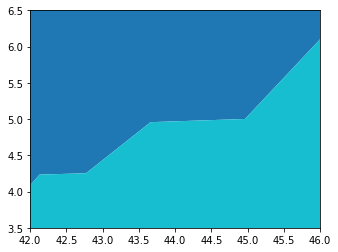

In [123]:
base = final3.plot(column='COUNTRY')
_ = base.set_xlim(42, 46)
_ = base.set_ylim(3.5, 6.5)

In [124]:
h4 = geoplanar.holes(final3)
h4.shape

(0, 3)